In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torch.nn import DataParallel
from torchvision import models, transforms, datasets
from torchvision.datasets import ImageFolder
import numpy as np
import time
import copy
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Check available devices
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Check if multiple GPUs are available
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    multi_gpu = True
else:
    print("Using single GPU")
    multi_gpu = False

Using device: cuda
Using 2 GPUs!


In [3]:
# Define batch size and other hyperparameters
BATCH_SIZE = 32
LEARNING_RATE = 0.001
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
STEP_SIZE = 7
GAMMA = 0.1
EPOCHS = 15

In [4]:
# Define data transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.RandomRotation(5),  # Add slight rotation for augmentation
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),  # Add slight translation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])  # Normalized for grayscale
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])  # Normalized for grayscale
])

In [5]:
# Set dataset path
dataset_path = '/kaggle/input/devanagaridataset'

# Load full dataset (no transforms yet)
full_dataset = datasets.ImageFolder(root=dataset_path)

# Get number of classes
num_classes = len(full_dataset.classes)
print(f"Number of classes: {num_classes}")
print(f"Class names: {full_dataset.classes}")

# Step 1: Split into 80% Train, 20% Test
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(1337))

# Step 2: Split the train dataset into 85% Train and 15% Validation
train_sub_size = int(0.85 * len(train_dataset))
val_size = len(train_dataset) - train_sub_size
train_dataset, val_dataset = random_split(train_dataset, [train_sub_size, val_size], generator=torch.Generator().manual_seed(1337))

# Apply transforms separately
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = test_transform
test_dataset.dataset.transform = test_transform

Number of classes: 41
Class names: ['CC_1', 'CC_10', 'CC_11', 'CC_12', 'CC_13', 'CC_14', 'CC_15', 'CC_16', 'CC_17', 'CC_18', 'CC_19', 'CC_2', 'CC_20', 'CC_21', 'CC_22', 'CC_23', 'CC_24', 'CC_25', 'CC_26', 'CC_27', 'CC_28', 'CC_29', 'CC_3', 'CC_30', 'CC_31', 'CC_32', 'CC_33', 'CC_34', 'CC_35', 'CC_36', 'CC_37', 'CC_38', 'CC_39', 'CC_4', 'CC_40', 'CC_41', 'CC_5', 'CC_6', 'CC_7', 'CC_8', 'CC_9']


In [6]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [7]:
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Training dataset size: 34013
Validation dataset size: 6003
Test dataset size: 10004


In [8]:
model = models.vgg16(pretrained=True)
print("VGG16 model loaded successfully")

# Modify first conv layer to accept grayscale input (1 channel instead of 3)
original_conv1 = model.features[0]
model.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)

# Transfer weights from pretrained model's first layer to new conv layer by averaging channels
with torch.no_grad():
    new_weight = original_conv1.weight.data.mean(dim=1, keepdim=True)
    model.features[0].weight.data = new_weight

# Modify final fully connected layer for our number of classes
model.classifier[6] = nn.Linear(4096, num_classes)

# Move model to device
model = model.to(device)

# Use DataParallel for multi-GPU training
if multi_gpu:
    model = nn.DataParallel(model)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 233MB/s] 


VGG16 model loaded successfully


In [10]:
# Function to train one epoch
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        total_samples += inputs.size(0)
    
    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples * 100
    
    return epoch_loss, epoch_acc.item()

In [11]:
# Function to validate the model
def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)
    
    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples * 100
    
    return epoch_loss, epoch_acc.item()

In [12]:
# Lists to track progress
train_losses = []
val_losses = []
train_accs = []
val_accs = []
best_acc = 0.0

In [13]:
# Training loop
start_time = time.time()
best_model_wts = copy.deepcopy(model.state_dict())
print(f"Starting training for {EPOCHS} epochs...")

for epoch in range(EPOCHS):
    epoch_start = time.time()
    
    # Train and validate
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    
    # Step the scheduler
    scheduler.step()
    
    # Save the best model
    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
    
    # Record statistics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    epoch_time = time.time() - epoch_start
    
    # Print statistics
    print(f'Epoch {epoch+1}/{EPOCHS} | Time: {epoch_time:.0f}s')
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
    print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
    print('-' * 50)

Starting training for 15 epochs...
Epoch 1/15 | Time: 422s
Train Loss: 0.5327 | Train Acc: 85.01%
Val Loss: 0.1067 | Val Acc: 96.90%
Learning Rate: 0.001000
--------------------------------------------------
Epoch 2/15 | Time: 428s
Train Loss: 0.0794 | Train Acc: 97.58%
Val Loss: 0.0666 | Val Acc: 97.83%
Learning Rate: 0.001000
--------------------------------------------------
Epoch 3/15 | Time: 429s
Train Loss: 0.0461 | Train Acc: 98.48%
Val Loss: 0.0582 | Val Acc: 98.35%
Learning Rate: 0.001000
--------------------------------------------------
Epoch 4/15 | Time: 428s
Train Loss: 0.0302 | Train Acc: 98.94%
Val Loss: 0.0572 | Val Acc: 98.43%
Learning Rate: 0.001000
--------------------------------------------------
Epoch 5/15 | Time: 429s
Train Loss: 0.0245 | Train Acc: 99.18%
Val Loss: 0.0701 | Val Acc: 98.17%
Learning Rate: 0.001000
--------------------------------------------------
Epoch 6/15 | Time: 429s
Train Loss: 0.0189 | Train Acc: 99.40%
Val Loss: 0.0628 | Val Acc: 98.43%
Le

In [14]:
model.load_state_dict(best_model_wts)
total_time = time.time() - start_time
print(f'Training complete in {total_time // 60:.0f}m {total_time % 60:.0f}s')
print(f'Best Validation Accuracy: {best_acc:.2f}%')

Training complete in 107m 10s
Best Validation Accuracy: 98.82%


In [15]:
# Evaluate on test set
test_loss, test_acc = validate_epoch(model, test_loader, criterion, device)
print(f'Test accuracy: {test_acc:.2f}%')

Test accuracy: 98.96%


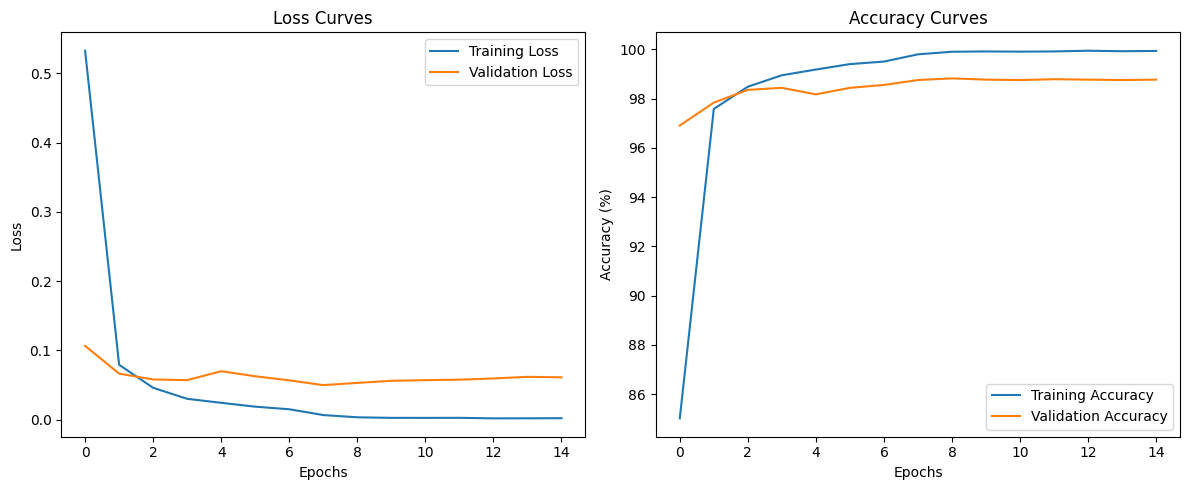

In [16]:
# Plot training curves
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curves')
plt.legend()

plt.tight_layout()
plt.savefig('training_curves.png')

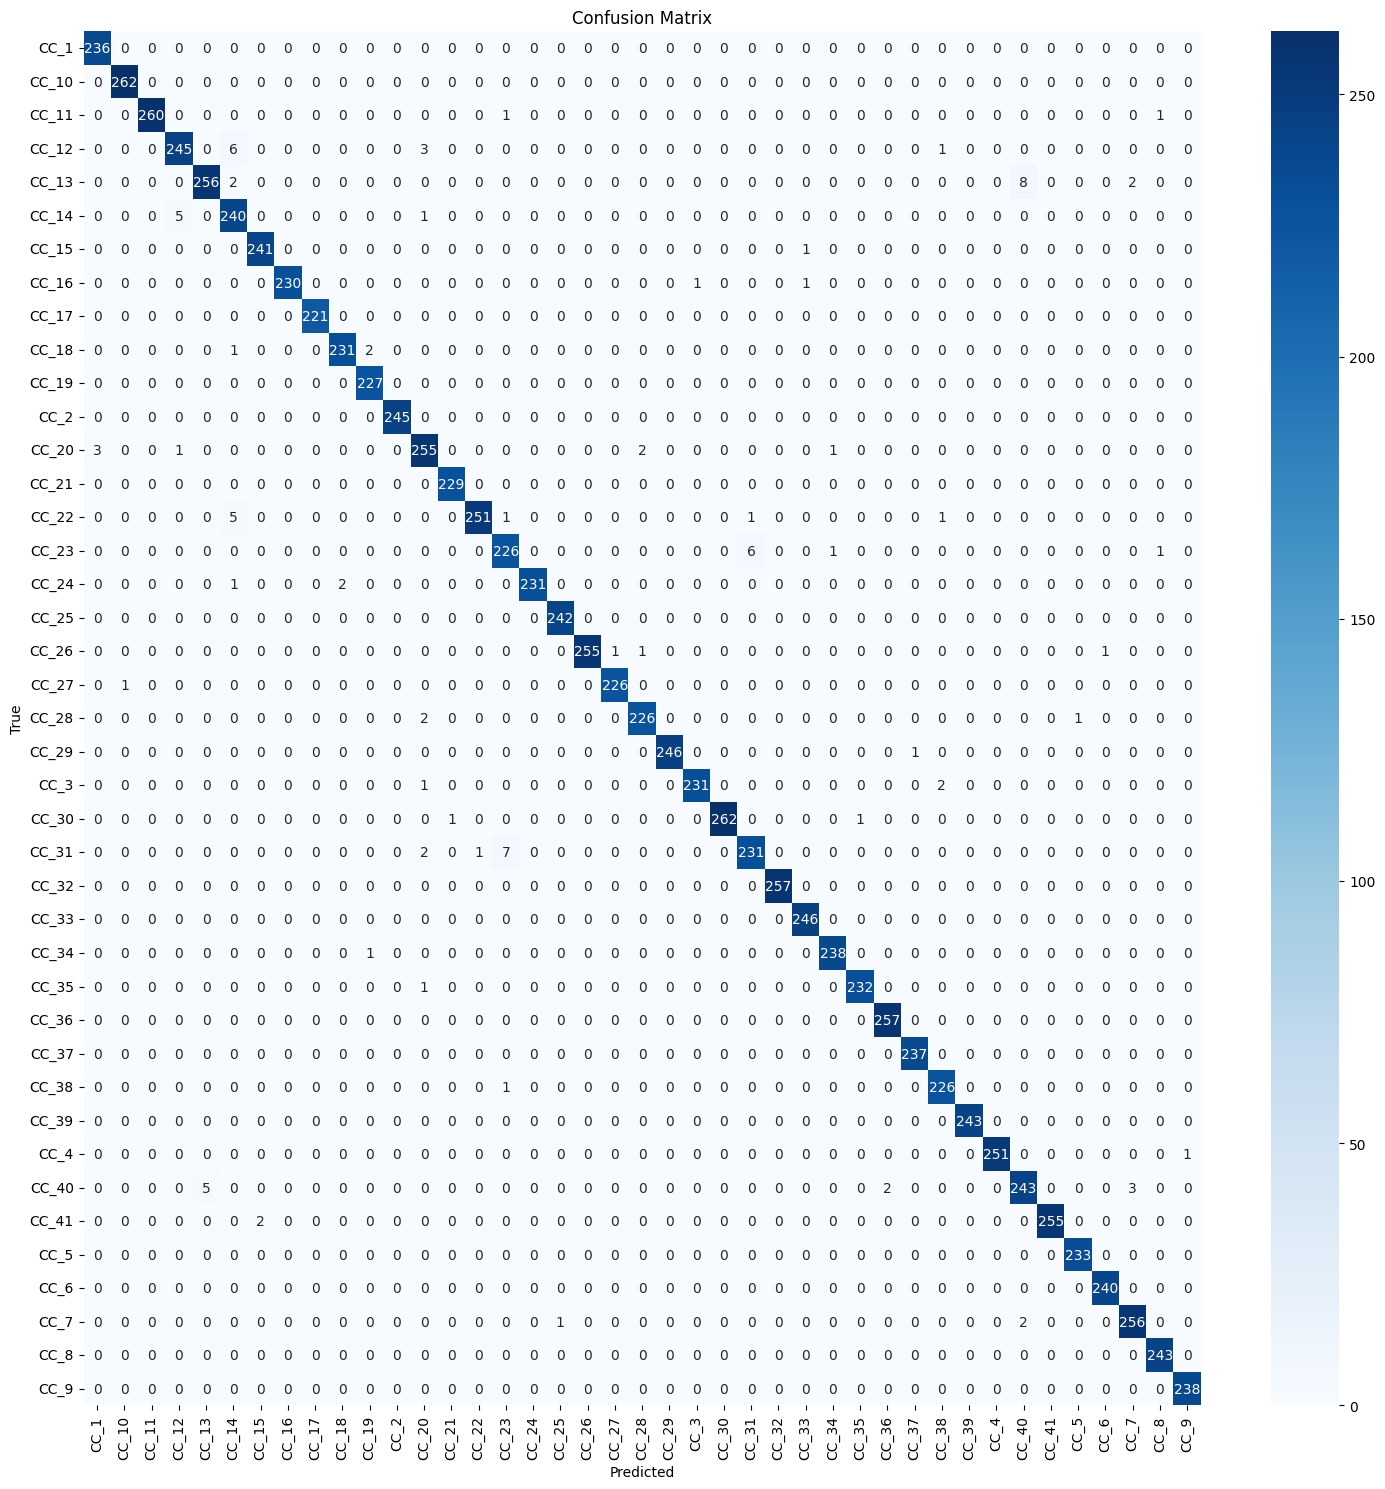

In [17]:
# Create a confusion matrix
def plot_confusion_matrix(model, dataloader, class_names):
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    
    # Store all predictions and true labels
    all_preds = []
    all_labels = []
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot confusion matrix
    plt.figure(figsize=(15, 15))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()

# Get class names from the dataset
class_names = full_dataset.classes

# Plot confusion matrix
plot_confusion_matrix(model, test_loader, class_names)

In [18]:
# Save the model
model_save_path = 'devanagri_conjunct_vgg_16_ourdata.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to devanagri_conjunct_vgg_16_ourdata.pth


In [19]:
from IPython.display import FileLink
FileLink(r'devanagri_conjunct_vgg_16_ourdata.pth')

/kaggle/working/devanagri_conjunct_vgg_16_ourdata.pth